In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict
sns.set_context('poster')

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.cross_validation import cross_val_score
import xgboost as xgb


import waterfall_chart


# Importing from my own modules
import sys
sys.path.append('../financial_forecasting/')
from utils import load_data, wMSE, train_and_test_models
from preprocessing import Imputer, LogTransformer, MeanEncoder, TreeBinner

/Users/km1308/anaconda/envs/py36/lib/python3.6/site-packages/pandas_profiling/plot.py:15: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Users/km1308/anaconda/envs/py36/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/km1308/anaconda/envs/py36/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/km1308/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/km1308/anaconda/envs/py36/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/km1308/anaconda/envs/py36/lib/pytho

# Custom functions

In [2]:
def train_model(model, X, y, w=None):
    
    if isinstance(w, (pd.DataFrame, pd.Series)):
        w = w.values
            
    print('Fitting: {}'.format(model))
    try:
        model.fit(X, y, sample_weight=w)
    except TypeError:
        print('This model does not accept sample weights')
        model.fit(X, y)
    return None
        

In [3]:
def test_model(model, X, y, w=None):
    preds = model.predict(X)
    error = wMSE(preds=preds, y=y, weights=w)
    return preds, error

In [4]:
def train_and_test_models(models, X_train, y_train, X_test, y_test, weights_train=None, weights_test=None):
    
    df_preds_train = pd.DataFrame()
    df_preds_test = pd.DataFrame()
    train_errors = OrderedDict()
    test_errors = OrderedDict()
    
    for model_name, model in models.items():
        # Training
        train_model(model, X_train, y_train, w=weights_train)
        
        # Test
        preds_train, train_error = test_model(model, X_train, y_train, weights_train)
        preds_test, test_error = test_model(model, X_test, y_test, weights_test)
        scale = 640430
        print('Train error: {} Test error: {} \n'.format(train_error * scale, test_error * scale))
        
        # Append test and train predictions to a dataframe
        data = {model_name + '_preds_train': preds_train}
        df = pd.DataFrame(data=data, index=X_train.index)
        df_preds_train = pd.concat([df_preds_train, df], axis=1)
        
        data = {model_name + '_preds_test': preds_test}
        df = pd.DataFrame(data=data, index=X_test.index)
        df_preds_test = pd.concat([df_preds_test, df], axis=1)
        
        # Attach weights
        if weights_train is not None:
            df_preds_train = df_preds_train.merge(right=weights_train.to_frame(), left_index=True, right_index=True)
            
        if weights_test is not None:
            df_preds_test = df_preds_test.merge(right=weights_test.to_frame(), left_index=True, right_index=True)
            
        # Save errors
        train_errors[model_name] = train_error
        test_errors[model_name] = test_error
        
    return df_preds_train, df_preds_test, train_errors, test_errors


# Load data

In [5]:
df_train, _ = load_data()


# Split data

In [6]:
# Seperate target variable and features
X = df_train.drop(labels=['y','Weight'], axis=1)
y = df_train.y
weights = df_train.Weight

# Train and test split
np.random.seed=42
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.30, random_state=42)
weights_train = weights[X_train.index]
weights_val = weights[X_val.index]

# Check size
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(436671, 14)
(436671,)
(187146, 14)
(187146,)


# Null model

In [7]:
class NullModel():
    def __init__(self):
        self.stock_mean = None
    
    def fit(self, df):
        stock_mean = df.groupby('Stock')['y'].mean()
        self.stock_mean = stock_mean
        
    def predict(self, df):
        preds = df['Stock'].map(self.stock_mean).rename('y')
        preds.fillna(0)
        return preds
    

In [8]:
scale = 640430
df = pd.concat([X_train, y_train], axis=1)

# Training
clf = NullModel()
clf.fit(df)

# Testing
preds_train = clf.predict(X_train)
preds_val = clf.predict(X_val)

train_error = wMSE(preds=preds_train, y=y_train, weights=weights_train)
val_error =  wMSE(preds=preds_val, y=y_val, weights=weights_val)

print('Train error: {} Test error: {} \n'.format(train_error * scale, val_error * scale))


Train error: 0.8345366387426115 Test error: 0.8203937948761544 



# Select models to test

In [10]:
models = OrderedDict([
                      ('LinearRegression', LinearRegression()), 
                      ('L1Regression', Lasso()),
                      ('L2Regression', Ridge(alpha=1)),
                      ('RandomForest', RandomForestRegressor(n_estimators=100, n_jobs=-1)),
                      ('XGB', xgb.sklearn.XGBRegressor(n_estimators=100, n_jobs=-1))
                    ])

training_errors = OrderedDict()
testing_errors = OrderedDict()


# Train models throughout stages of pre-processing

In [11]:
# Missing value imputation
imputer = Imputer()
imputer.fit(X_train)
X_train = imputer.transform(X_train)
X_val = imputer.transform(X_val)

df_preds_train, df_preds_test, train_error, test_error = train_and_test_models(models, X_train, y_train, 
                                                         X_val, y_val, 
                                                         weights_train, weights_val)


experiment_name = 'no_preprocessing'
training_errors[experiment_name] = train_error
testing_errors[experiment_name] = test_error


Fitting: LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
Train error: 0.9218747379525374 Test error: 0.8802769381947776 

Fitting: Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
This model does not accept sample weights
Train error: 1.0696949896476435 Test error: 1.0375608462880646 

Fitting: Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
Train error: 0.9412123456788133 Test error: 0.9054205198556043 

Fitting: RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=F

In [12]:
# Log transformation
features_to_log_trans = [f for f in df_train.columns if 'x' in f]
log_transformer = LogTransformer()
log_transformer.fit(X_train, features=features_to_log_trans)
X_train = log_transformer.transform(X_train)
X_val = log_transformer.transform(X_val)

df_preds_train, df_preds_test, train_error, test_error = train_and_test_models(models, X_train, y_train, 
                                                         X_val, y_val, 
                                                         weights_train, weights_val)

experiment_name = 'log_transform'
training_errors[experiment_name] = train_error
testing_errors[experiment_name] = test_error

../financial_forecasting/preprocessing.py:47: RuntimeWarning: divide by zero encountered in log10
  df[f + '_log10'] = np.log10(df[f])
../financial_forecasting/preprocessing.py:59: RuntimeWarning: divide by zero encountered in log10
  df[f + '_log10'] = np.log10(df[f])


Fitting: LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
Train error: 0.8505609961968214 Test error: 0.8161937891017568 

Fitting: Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
This model does not accept sample weights
Train error: 1.0696949896476435 Test error: 1.0375608462880646 

Fitting: Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
Train error: 0.8625572938252927 Test error: 0.8318695814194393 

Fitting: RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=F

In [13]:
# Tree based binning
features_to_bin = features_to_log_trans
tree_binner = TreeBinner()
tree_binner.fit(X_train, y_train, weights_train, features=features_to_bin)
X_train = tree_binner.transform(X_train)
X_val = tree_binner.transform(X_val)

df_preds_train, df_preds_test, train_error, test_error = train_and_test_models(models, X_train, y_train, 
                                                         X_val, y_val, 
                                                         weights_train, weights_val)

experiment_name = 'tree_binning'
training_errors[experiment_name] = train_error
testing_errors[experiment_name] = test_error

../financial_forecasting/preprocessing.py:142: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  return temp.depth[temp.mse_mean.argmax()]
../financial_forecasting/preprocessing.py:142: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  return temp.depth[temp.mse_mean.argmax()]
../financial_forecasting/preprocessing.py:142: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  return temp.depth[temp.mse_mean.argmax()]
../financial_forecasting/preprocessing.py:142: FutureWarning: 'argmax'

Fitting: LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
Train error: 0.8078221063777995 Test error: 0.7901931715394787 

Fitting: Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
This model does not accept sample weights
Train error: 1.0696949896476435 Test error: 1.0375608462880646 

Fitting: Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
Train error: 0.8604655892428186 Test error: 0.8302494401973843 

Fitting: RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=F

In [14]:
# Mean value encoding
encoder = MeanEncoder()
encoder.fit(X_train, features=['Market', 'Day', 'Stock'], target=y_train)
X_train = encoder.transform(X_train)
X_val = encoder.transform(X_val)

df_preds_train, df_preds_test, train_error, test_error = train_and_test_models(models, X_train, y_train, 
                                                         X_val, y_val, 
                                                         weights_train, weights_val)

experiment_name = 'mean_value_encoding'
training_errors[experiment_name] = train_error
testing_errors[experiment_name] = test_error

Detected unseen values for encoding for feature Stock: {33, 139, 561, 734, 1396, 1407, 1755, 1779, 1945, 1989, 2076, 2888, 2947}
Fitting: LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
Train error: 0.7312979435432946 Test error: 0.7251427420257832 

Fitting: Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
This model does not accept sample weights
Train error: 1.0696949896476435 Test error: 1.0375608462880646 

Fitting: Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
Train error: 0.8516455305965083 Test error: 0.8225185099109242 

Fitting: RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_

In [15]:
# MinMax scaling for linear models
minmax = MinMaxScaler()
minmax.fit(X_train)
X_train_ = minmax.transform(X_train)
X_val_ = minmax.transform(X_val)

X_train_minmax = pd.DataFrame(data=X_train_, columns=X_train.columns, index=X_train.index)
X_val_minmax = pd.DataFrame(data=X_val_, columns=X_val.columns, index=X_val.index)

df_preds_train, df_preds_test, train_error, test_error = train_and_test_models(models, X_train_minmax, y_train, 
                                                         X_val_minmax, y_val, 
                                                         weights_train, weights_val)

experiment_name = 'min_max_scaling'
training_errors[experiment_name] = train_error
testing_errors[experiment_name] = test_error

Fitting: LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
Train error: 0.7312979435432941 Test error: 0.7251427419643077 

Fitting: Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
This model does not accept sample weights
Train error: 1.0696949896476435 Test error: 1.0375608462880646 

Fitting: Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
Train error: 0.7334875576656454 Test error: 0.7280822703034546 

Fitting: RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=F

In [16]:
# Standard scaling for linear models
stadardiser = StandardScaler()
stadardiser.fit(X_train)
X_train_ = stadardiser.transform(X_train)
X_val_ = stadardiser.transform(X_val)

X_train_s = pd.DataFrame(data=X_train_, columns=X_train.columns, index=X_train.index)
X_val_s = pd.DataFrame(data=X_val_, columns=X_val.columns, index=X_val.index)

df_preds_train, df_preds_test, train_error, test_error = train_and_test_models(models, X_train_s, y_train, 
                                                         X_val_s, y_val, 
                                                         weights_train, weights_val)

experiment_name = 'standard_scaling'
training_errors[experiment_name] = train_error
testing_errors[experiment_name] = test_error

Fitting: LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
Train error: 0.7312979435432942 Test error: 0.7251427419643072 

Fitting: Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
This model does not accept sample weights
Train error: 1.0696949896476435 Test error: 1.0375608462880646 

Fitting: Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
Train error: 0.7312979441502568 Test error: 0.7251433604406498 

Fitting: RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=F

# Waterfall charts

We examine the contribution of each preprocessing step on reducing the error

In [17]:
# Need to invert keys of the dictionary so model comes first
from collections import defaultdict
flipped = defaultdict(dict)
for key, val in testing_errors.items():
    for subkey, subval in val.items():
        flipped[subkey][key] = subval
        
# To return to correct ordering later        
ix = ['no_preprocessing', 
      'log_transform',
      'tree_binning',
      'mean_value_encoding',
      'min_max_scaling',
      'standard_scaling'
     ]

LinearRegression 
 no_preprocessing      -0.000000e+00
log_transform          1.000627e-01
tree_binning           4.059869e-02
mean_value_encoding    1.015731e-01
standard_scaling       9.599191e-11
dtype: float64
L1Regression 
 no_preprocessing      -0.0
log_transform         -0.0
tree_binning          -0.0
mean_value_encoding   -0.0
standard_scaling      -0.0
dtype: float64


/Users/km1308/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/axes/_base.py:3285: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))


L2Regression 
 no_preprocessing      -0.000000
log_transform          0.114846
tree_binning           0.002530
mean_value_encoding    0.012071
standard_scaling       0.152047
dtype: float64
RandomForest 
 no_preprocessing      -0.000000
log_transform         -0.009162
tree_binning           0.001578
mean_value_encoding    0.069653
standard_scaling      -0.001406
dtype: float64
XGB 
 no_preprocessing      -0.000000
log_transform          0.000311
tree_binning          -0.002097
mean_value_encoding   -0.002518
standard_scaling      -0.000915
dtype: float64


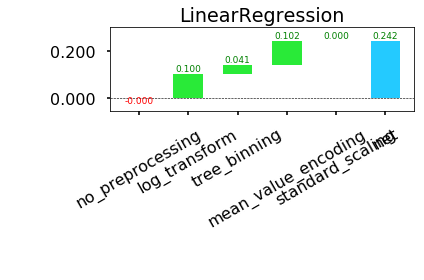

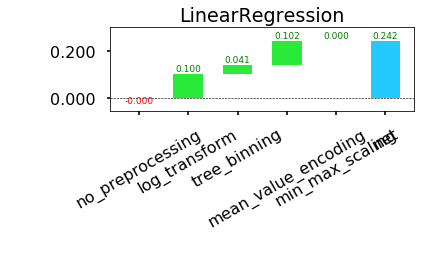

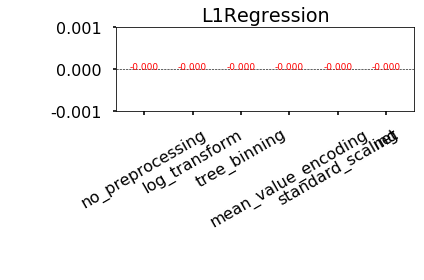

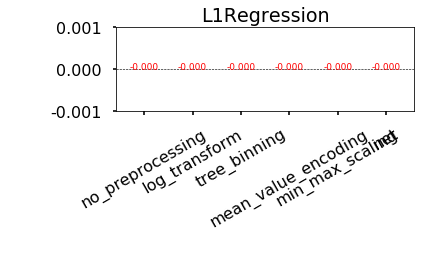

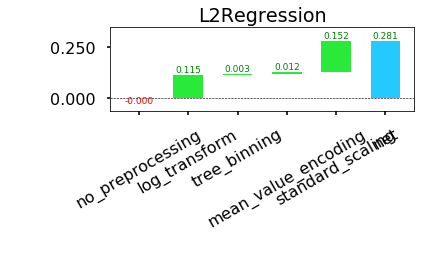

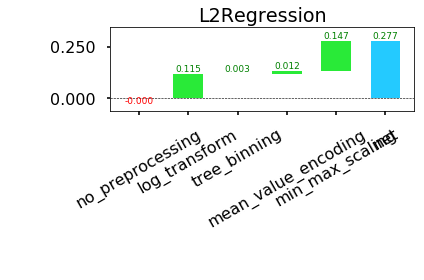

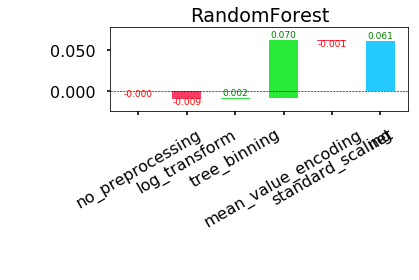

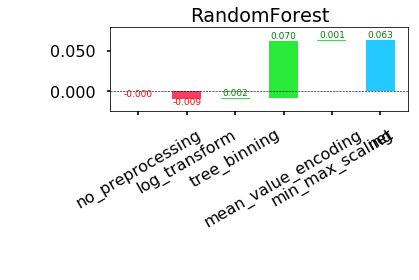

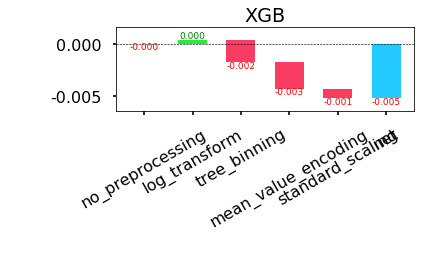

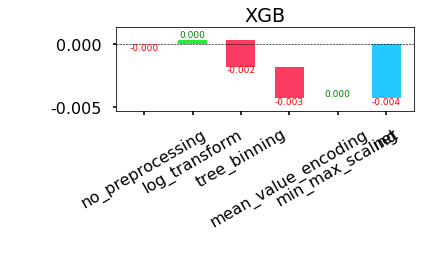

In [36]:
for model_name in models.keys():  
    d = pd.Series(data=flipped[model_name])
    d = d[ix]
    differential_performance = -1e6*(d.drop(labels='min_max_scaling')).diff().fillna(0)
    print(model_name,'\n',differential_performance)
    waterfall_chart.plot(index=differential_performance.index, 
                         data=differential_performance.values,
                         formatting="{:,.3f}", Title=model_name)

    d = pd.Series(data=flipped[model_name])
    d = d[ix]
    differential_performance = -1e6*(d.drop(labels='standard_scaling')).diff().fillna(0)
    waterfall_chart.plot(index=differential_performance.index,
                         data=differential_performance.values,
                         formatting="{:,.3f}", Title=model_name)

### Model Stacking

In [ ]:
error = wMSE(preds=preds_v.simple_average, y=y_val, weights=weights_val)
print(error*scale)

In [ ]:
preds_t['simple_average'].rename('y').to_csv('../data/output.csv', header=True)

In [16]:
preds_v['simple_average'] = (preds_v.L2Regression_preds_val + preds_v.RF_preds_val + preds_v.LinearRegression_preds_val)/3
preds_t['simple_average'] = (preds_t.L2Regression_preds_test + preds_t.RF_preds_test + preds_t.LinearRegression_preds_test)/3

In [17]:
error = wMSE(preds=preds_v.simple_average, y=y_val, weights=weights_val)
print(error*scale)

0.7495505543625007


In [18]:
preds_t['simple_average'].rename('y').to_csv('../data/output.csv', header=True)

In [ ]:
# Learning curve
train_errors = []
test_errors = []
data_size = []
for N in range(1000,42000,5000):
    X_train_ = X_train.iloc[:N, :]
    y_train_ =  y_train.iloc[:N]
    weights_train_ = weights_train.iloc[:N]

    clf = RandomForestRegressor(n_estimators=100)
    clf.fit(X_train_, y_train_, sample_weight=weights_train_.values)
    
    preds_train = clf.predict(X_train_)
    preds_test = clf.predict(X_test)
    
    train_error = wMSE(preds=preds_train, y=y_train_, weights=weights_train_)
    test_error =  wMSE(preds=preds_test, y=y_test, weights=weights_test)
    
    print('Data size: {} Train error: {} Test error: {}'.format(N,train_error * 1e6, test_error*1e6))
    
    train_errors.append(train_error)
    test_errors.append(test_error)
    data_size.append(N)
    
plt.plot(data_size, train_errors)
plt.plot(data_size, test_errors)

In [ ]:
# Sanity check
df_train_error = pd.DataFrame({'preds_train':preds_train, 'y_train':y_train, 'weights_train':weights_train})
df_train_error['Diff'] = df_train_error.preds_train - df_train_error.y_train
df_train_error['wMSE'] = np.square(df_train_error.Diff) * df_train_error.weights_train
print(df_train_error.wMSE.sum() / len(df_train_error))

## Feature importance

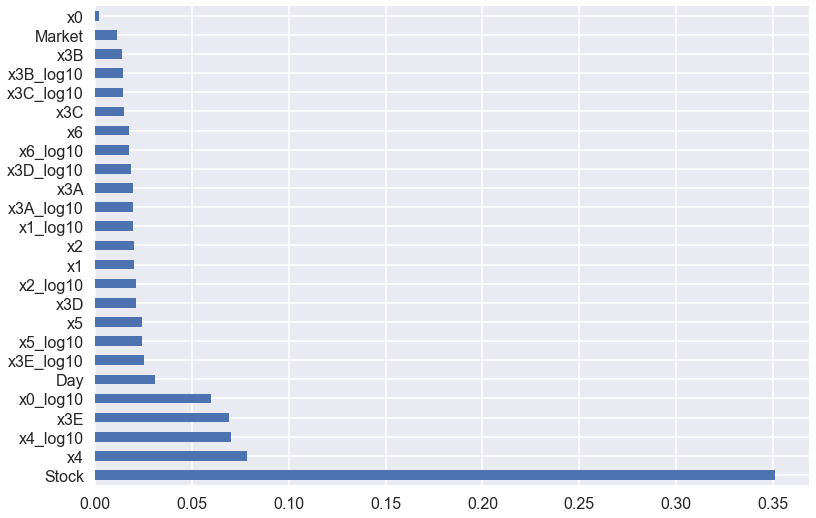

In [23]:
feat_importance = pd.Series(dict(zip(X_train.columns, models['RandomForest'].feature_importances_))).sort_values(ascending=False)
feat_importance[feat_importance > 1e-4].plot(kind='barh')

In [ ]:
clf.get_params()

# Output 

In [ ]:
preds_t['simple_average'].rename('y').to_csv('../data/output.csv', header=True)